In [ ]:

"""
Reads a CSV of hourly data from one of the 5 tripods
and plots 6 panels: Temperature, Relative Humidity, Pressure, Solar Radiation,
Wind Speed, Wind Direction.

Usage: run the script and enter the CSV filename when prompted.
"""

import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --------------- interactive input ----------------
infile = input("Enter path to the hourly-climatology CSV file: ").strip()
if not os.path.exists(infile):
    print(f"File not found: {infile}")
    sys.exit(1)

# -------- read CSV (expect exact columns) --------
df = pd.read_csv(infile)

expected = ["Year","Month","Day","Hour","AirTC_Avg","RH","BP_hPa",
            "SlrW_Avg","Wind_Speed_ms","Wind_Direction_deg","Count"]
missing = [c for c in expected if c not in df.columns]
if missing:
    print("Missing columns:", missing)
    print("CSV columns:", df.columns.tolist())
    sys.exit(1)

df = pd.read_csv(infile)

In [ ]:
#Year,Month,Day,Hour,AirTC_Avg,RH,BP_hPa,SlrW_Avg,Wind_Speed_ms,Wind_Direction_deg,Count

# make all plots and get uv winds
df["AirRC_Avg"] = df["AirTC_Avg"].to_numpy(dtype=float)
df["RH"]  = df["RH"].to_numpy(dtype=float)
df["BP_hPa"] = df["BP_hPa"].to_numpy(dtype=float)
df["SlrW_Avg"] = df["SlrW_Avg"].to_numpy(dtype=float)
df["Wind_Speed_ms"] = df["Wind_Speed_ms"].to_numpy(dtype=float)
df["Wind_Direction_deg"] = df["Wind_Direction_deg"].to_numpy(dtype=float)  # degrees meteorological (from)

dir_rad = np.deg2rad(df["Wind_Direction_deg"])
u = - df["Wind_Speed_ms"] * np.sin(dir_rad)   # zonal (m/s), positive eastward
v = - df["Wind_Speed_ms"] * np.cos(dir_rad)   # meridional (m/s), positive northward
df["U"] = u
df["V"] = v

In [7]:
# Ensure Hour is int 0..23
df["Hour"] = pd.to_numeric(df["Hour"], errors="coerce").astype('Int64')
df = df.dropna(subset=["Hour"])
df["Hour"] = df["Hour"].astype(int) % 24

# Build aggregate indexed by Hour (if duplicates, take mean)
hourly = df.groupby("Hour").mean(numeric_only=True)

# Ensure all 0..23 present (fill missing with NaN)
hours = np.arange(24)
hourly = hourly.reindex(hours)
hourly = hourly.drop(columns=["Year", "Month", "Day"], errors="ignore")
# mean wind direction (meteorological 'from' degrees): convert back from vector
# We computed u = -WS*sin(dir), v = -WS*cos(dir).
# To recover meteorological direction from ubar,vbar:
Ubar = hourly["U"].to_numpy()
Vbar = hourly["V"].to_numpy()
mean_dir_rad = np.arctan2(-Ubar, -Vbar)
mean_dir_deg = (np.degrees(mean_dir_rad) % 360.0)
hourly["Wind_Direction_deg"] = mean_dir_deg


Saved figure: salmon_2762439_189210817_LAB4_2025_11_20_15_25_47_hourly_panel.png


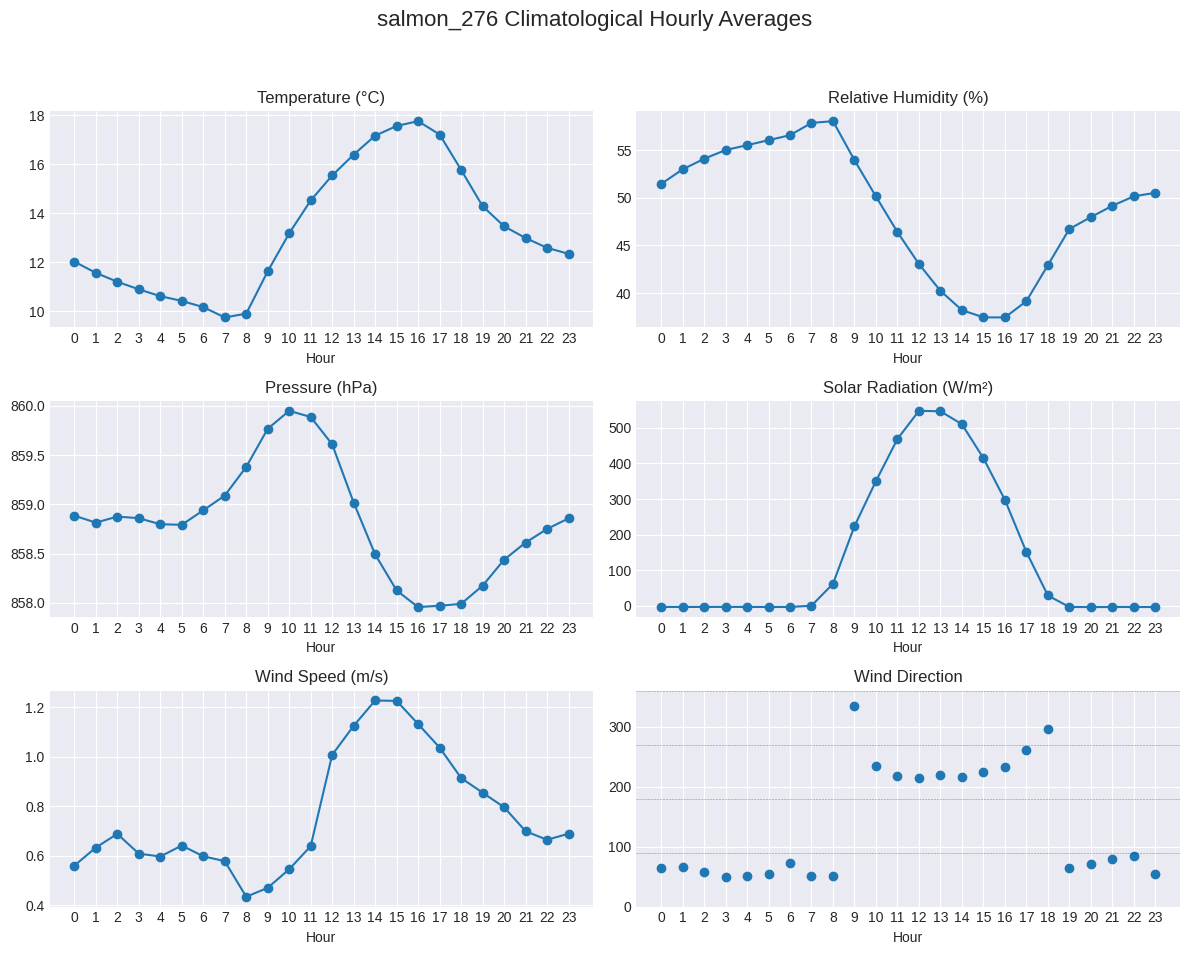

In [8]:

# If near-zero vector speed, wind dir may be meaningless - no special handling required here,
# but you can mask tiny speeds if desired.

# -------- plotting --------
plt.style.use("seaborn-darkgrid")
fig, axs = plt.subplots(3,2, figsize=(12,10))
axs = axs.flatten()

hours_ticks = hours

# Temperature
axs[0].plot(hours, hourly["AirTC_Avg"], marker='o')
axs[0].set_title("Temperature (°C)")
axs[0].set_xticks(hours_ticks)

# Relative Humidity
axs[1].plot(hours, hourly["RH"], marker='o')
axs[1].set_title("Relative Humidity (%)")
axs[1].set_xticks(hours_ticks)

# Pressure
axs[2].plot(hours, hourly["BP_hPa"], marker='o')
axs[2].set_title("Pressure (hPa)")
axs[2].set_xticks(hours_ticks)

# Solar Radiation
axs[3].plot(hours, hourly["SlrW_Avg"], marker='o')
axs[3].set_title("Solar Radiation (W/m²)")
axs[3].set_xticks(hours_ticks)

# Wind speed
axs[4].plot(hours, hourly["Wind_Speed_ms"], marker='o')
axs[4].set_title("Wind Speed (m/s)")
axs[4].set_xticks(hours_ticks)

axs[5].plot(hours, hourly["Wind_Direction_deg"], marker='o',linestyle='None')
axs[5].set_title("Wind Direction")
axs[5].set_xticks(hours_ticks)
    # add faint horizontal lines at cardinal directions (and their repeats if unwrapped spans >360)
base_min = 0
base_max = 360
axs[5].set_ylim([0.,360.])
for m in range(base_min, base_max+1):
    for d in (0, 90, 180, 270):
        axs[5].axhline(m*360 + d, color='k', linestyle='--', linewidth=0.4, alpha=0.4)

# labels & layout
for ax in axs:
    ax.set_xlabel("Hour")
    ax.grid(True)

plt.suptitle(f"{infile[0:10]} Climatological Hourly Averages", fontsize=16)
plt.tight_layout(rect=[0,0.03,1,0.95])

# save figure next to input file
base, _ = os.path.splitext(infile)
outfig = f"{base}_panel.png"
fig.savefig(outfig, dpi=200)
print("Saved figure:", outfig)

plt.show()
